In [1]:
import numpy as np
np.random.seed(0)

import pandas as pd
#df = pd.read_csv('Anne_DNA_66.csv')
#df = pd.read_csv('Mark_DNA_75.csv')
df = pd.read_csv('../subpop_data/B6_robust_linear_training.txt', sep='\t', header=None)

In [2]:
# Downsampling Naive
df = df[df[0] != 'interphase']
#df_x = pd.read_csv('Anne_DNA_66.csv')
#df_x = pd.read_csv('Mark_DNA_75.csv')
#trimmed_interphase = df_x[df_x['Class'] == 'interphase'].head(150)
df_x = pd.read_csv('../subpop_data/B6_robust_linear_training.txt', sep='\t', header=None)

trimmed_interphase = df_x[df_x[0] == 'interphase'].head(150)
df = pd.concat([df, trimmed_interphase],axis=0) # Add interphase but balanced

In [3]:
y = df[0].values

In [4]:
# df = df.drop('TableNumber', 1)
# df = df.drop('ImageNumber', 1)
# df = df.drop('ObjectNumber', 1)
# df = df.drop('Class', 1)
# df = df.drop('Nuclei_AreaShape_EulerNumber', 1)
df = df.drop(0,1)
df = df.drop(1,1)
#df

In [5]:
#df_norm = (df - df.mean()) / (df.max() - df.min())
#df_norm.values.shape

df_norm = df
X_train = df_norm.values

In [ ]:
np.unique(y)

In [ ]:
from sklearn.cross_validation import train_test_split
X_train_original, X_test, y_train_original, y_test = train_test_split(df.values, y, test_size=0.20, random_state=42)

# from unbalanced_dataset import OverSampler

# sampler = OverSampler()
# X_train, y = sampler.fit_transform(X_train_original, y_train_original)

# No Over Sampling
X_train = X_train_original
y = y_train_original

In [6]:
# Convert y into Y
nb_classes = 23
import numpy as np
from keras.utils import np_utils, generic_utils

# Convert labels to numeric
y_unique = np.unique(y)
dic = {}
labels = []
for i, label in enumerate(y_unique):
    dic[label] = i
    labels += [label]
print dic

y_numeric = []
for el in y:
    y_numeric += [dic[el]]
    
y_numeric # now a 2000 label vector
Y = np_utils.to_categorical(y_numeric, nb_classes)

print Y.shape

Y_train = Y
labels

{'halfcircle': 7, 'interphase': 10, 'metaphase': 15, 'earlyprophase': 4, 'debris': 3, 'nucleolirim': 19, 'kidney': 11, 'telophase': 22, 'blurry': 2, 'fragmented': 6, 'apoptotic': 1, 'multinucleate': 18, 'latepro_earlyana': 12, 'prophase': 20, 'anaphase': 0, 'indented': 9, 'monopole': 17, 'holey': 8, 'latetelophase': 13, 'lines': 14, 'micronucleus': 16, 'round': 21, 'elongated': 5}
(1456, 23)


['anaphase',
 'apoptotic',
 'blurry',
 'debris',
 'earlyprophase',
 'elongated',
 'fragmented',
 'halfcircle',
 'holey',
 'indented',
 'interphase',
 'kidney',
 'latepro_earlyana',
 'latetelophase',
 'lines',
 'metaphase',
 'micronucleus',
 'monopole',
 'multinucleate',
 'nucleolirim',
 'prophase',
 'round',
 'telophase']

In [8]:
y_train_original_numeric = []
for el in y_train_original:
    y_train_original_numeric += [dic[el]]

y_test_numeric = []
for el in y_test:
    y_test_numeric += [dic[el]]

Y_test = np_utils.to_categorical(y_test_numeric, nb_classes)

np.array(y_test_numeric)

NameError: name 'y_test' is not defined

In [13]:
y_test_numeric = y_numeric_eval
X_test = X_eval

In [9]:
from sklearn.cross_validation import StratifiedKFold

#print y_numeric
skl = StratifiedKFold(y_numeric, n_folds=10)

y_numeric = np.array(y_numeric)

i = 0
for train,test in skl:
    print len(train), len(test)
    
X_4 = X_train[train]
Y_4 = Y[train]
y_numeric_4 = y_numeric[train]

X_eval = X_train[test]
Y_eval = Y[test]
y_numeric_eval = y_numeric[test]

X_stratified = np.append(X_4,X_eval,axis=0)
Y_stratified = np.append(Y_4,Y_eval,axis=0)

X_stratified.shape
Y_stratified.shape

1302 154
1303 153
1306 150
1307 149
1309 147
1310 146
1312 144
1316 140
1318 138
1321 135


(1456, 23)

In [10]:
## Convolutional Neural Network with 2 convolutions
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU

nb_epoch = 12

Using TensorFlow backend.


In [11]:
model = Sequential()
model.add(Dense(64, input_dim=97))
#model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
#model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
#model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(23))
model.add(Activation('softmax'))

## Training with 5000 iterations and 0.1 holdout resulted in 66.3 % accuracy!

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=97))
model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(512))
model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(4096))
model.add(BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(23))
model.add(Activation('softmax'))

## Training with 5000 iterations and 0.1 holdout resulted in 66.3 % accuracy!

In [12]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [ ]:
import keras.backend as K
session = K.tensorflow_backend._get_session()
session.close()

import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
config=tf.ConfigProto(gpu_options=gpu_options)
session = tf.Session(config=config)
K.tensorflow_backend._set_session(session)

In [ ]:
tf_cb = keras.callbacks.TensorBoard(log_dir='./logs/lower_learning_rate/', histogram_freq=0)

# Learning rate lowering
def learning_rate(index):
    if (index > 2000):
        return 0.005
    else:
        return 0.01
l_cb = keras.callbacks.LearningRateScheduler(learning_rate)

In [ ]:
history = model.fit(X_stratified, Y_stratified, nb_epoch=3000,validation_split=0.1, show_accuracy=True, verbose=2, 
                    callbacks = [tf_cb, l_cb])

In [ ]:
import skflow
from sklearn import datasets, metrics

clf = skflow.TensorFlowDNNClassifier(hidden_units=[64,256,4096], n_classes=23, steps=5000, batch_size=len(X_4))
clf.fit(X_4, y_numeric_4, logdir='/tmp/tf_examples/model_without_dropout/')

In [ ]:
from sklearn import datasets, metrics
score = metrics.accuracy_score(y_test_numeric, model.predict_classes(X_test))
print("Accuracy: %f" % score)

cm = metrics.confusion_matrix(y_test_numeric, model.predict_classes(X_test))
cm_norm = cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm)
plt.show()

In [ ]:
from sklearn import datasets, metrics
iris = datasets.load_iris()
iris.target.shape

In [ ]:
# Creates a graph.
import tensorflow as tf
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
clf = skflow.TensorFlowDNNClassifier(hidden_units=[64,256,8096], n_classes=23, steps=5000, batch_size=len(X_4), 
                                     learning_rate=0.05, early_stopping_rounds=1000)
clf.fit(X_4, y_numeric_4, logdir='/tmp/tf_examples/model_with_dropout_and_early_stopping/')

In [ ]:
score = metrics.accuracy_score(y_numeric_eval, clf.predict(X_eval))
print("Accuracy: %f" % score)

In [ ]:
clf.save('dropout_DNN_model')

In [14]:
from sklearn.lda import LDA

/home/ddao/.deep/local/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [15]:
lda = LDA()
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

def plot_confusion_matrix(cm, title='Normalized Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy LDA: 0.607407


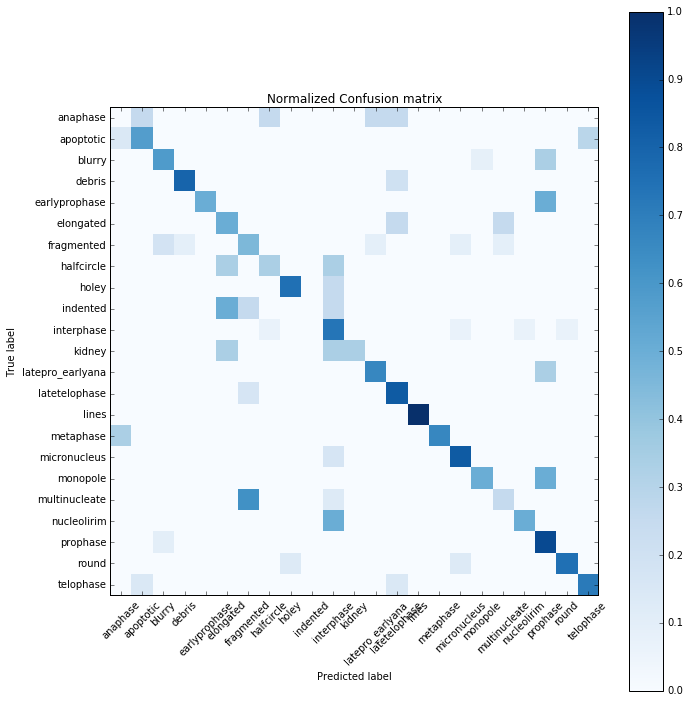

In [18]:
lda.fit(X_4,y_numeric_4)
from sklearn import datasets, metrics
score = metrics.accuracy_score(y_test_numeric, lda.predict(X_test))
print("Accuracy LDA: %f" % score)

cm = metrics.confusion_matrix(y_test_numeric, lda.predict(X_test))
cm_norm = cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm)
plt.show()

In [ ]:
lda.fit(X_train,y_numeric)
from sklearn import datasets, metrics
score = metrics.accuracy_score(y_test_numeric, lda.predict(X_test))
print("Upsampled Accuracy LDA: %f" % score)

cm = metrics.confusion_matrix(y_test_numeric, lda.predict(X_test))
cm_norm = cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_original,y_train_original_numeric)
from sklearn import datasets, metrics
score = metrics.accuracy_score(y_test_numeric, rf.predict(X_test))
print("Accuracy RF: %f" % score)

metrics.confusion_matrix(y_test_numeric, rf.predict(X_test))

cm = metrics.confusion_matrix(y_test_numeric, rf.predict(X_test))
cm_norm = cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm)
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_numeric)
from sklearn import datasets, metrics
score = metrics.accuracy_score(y_test_numeric, rf.predict(X_test))
print("Upsampled Accuracy RF: %f" % score)

metrics.confusion_matrix(y_test_numeric, rf.predict(X_test))

cm = metrics.confusion_matrix(y_test_numeric, rf.predict(X_test))
cm_norm = cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm)
plt.show()

In [ ]:
# Real data
# Load the full data
df_full = pd.read_csv('../subpop_data/B6_robust_linear_test.txt', sep='\t', header=None)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_numeric)
# Get all columns of the training data
#training_values = training_df.columns.values

In [ ]:
# Get the column labels 
training_values = df.columns.values
df_full_trimmed = df_full[training_values]

In [ ]:
# Normalize
df_full_norm = (df_full_trimmed - df_full_trimmed.mean()) / (df_full_trimmed.max() - df_full_trimmed.min())
df_full_norm.values.shape

In [ ]:
df_full.describe()
df_full = df_full.drop(0,1)
df_full = df_full.drop(1,1)

In [ ]:
# Too large!
# rf.predict(df_full_norm.values)

In [ ]:
matrix = df_full.values

In [ ]:
matrix.shape

In [ ]:
matrix[0:,:].shape 

In [ ]:
df_full

In [ ]:
indices = [5000 * i for i in range(435)]

In [ ]:
result = np.array([])
for i in range(len(indices) - 1):
    predictions = model.predict_classes(matrix[indices[i]:indices[i+1],:])
    result = np.append(result, predictions)

In [ ]:
result.shape

In [ ]:
np.save('robust_linear_result_28_2.npy',result)

In [ ]:
import numpy as np

In [ ]:
result = np.load('rf_result.npy')

In [ ]:
result

In [ ]:
# Make it categorical to sum up the profiles
from keras.utils import np_utils
Y = np_utils.to_categorical(result, 23)

In [ ]:
import pandas as pd
images = pd.read_csv('../images.csv')

In [ ]:
cc = images[['Image_Metadata_Compound','Image_Metadata_Concentration']]
cc[cc['Image_Metadata_Compound'] == 'AZ-A'][cc['Image_Metadata_Concentration'] == 30.0]

In [ ]:
indexed_images = images.set_index(['TableNumber','ImageNumber'])

In [ ]:
indexed_images

In [ ]:
joined_df = df_full.join(indexed_images, on=['TableNumber','ImageNumber'])

In [ ]:
df_full

In [ ]:
np.unique(df_full['ImageNumber'])

In [ ]:
images.shape

In [ ]:
model.save_weights('24-2-11:39.h5')

In [ ]:
np.array(y_train_original_numeric).shape

In [ ]:
np.array(y_numeric).shape

In [ ]:
arr = np.array(y_test_numeric)

assert isinstance(arr, np.ndarray)